# Exercises notebook 
##Imports and definitions
### First things firsts. Here we will import all necessary libraries and defined earlier functions to make your tasks more oriented just on Wavelets

In [1]:
import pywt # Library for wavelets operations
import numpy as np # Library for array and matrix manipulations
import math # Librarry for many mathematical operations
import tftb # time-frequency-tool-box - signal processing
from scipy.special import expit
from scipy import misc
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt # Library for ploting
import matplotlib as mpl

In [45]:
def plot_orthogonal_wavelet_aprox(wavelet, level):
    phi, psi, x = wavelet.wavefun(level)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_size_inches(15,4)
    ax1.plot(x,phi, color = 'red', label = 'Scalling')
    ax2.plot(x, psi, color = 'green', label = 'Wavelet')
    ax1.set_title('Scalling function', color = 'red')
    ax2.set_title('Wavelet function', color ='green')

def plot_not_orthogonal_wavelet_aprox(wavelet, level):
    phi_d, psi_d, phi_r, psi_r, x = wavelet.wavefun(level)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    f.set_size_inches(15,8)
    ax1.plot(x, phi_r, color = 'red', label = 'Scalling')
    ax1.set_title('Reconstruction scalling', color ='red')
    ax2.plot(x, psi_r, color = 'green', label = 'Wavelet')
    ax2.set_title('Reconstruction wavelet', color ='green')
    ax3.plot(x, phi_d, color = 'blue', label = 'Scalling')
    ax3.set_title('Decomposition scalling', color ='blue')
    ax4.plot(x, psi_d, color = 'orange', label = 'Wavelet')
    ax4.set_title('Decomposition wavelet', color ='orange')
    
def plot_decomposition_coefficients(coeffs):
    colors=['b','g','r','c','m','y','k']
    f, ax =plt.subplots(len(coeffs),1,sharex=True)
    f.set_size_inches(15,2*len(coeffs))
    ax[0].plot(coeffs[0], color='blue', label="aproximated coeff")
    ax[0].legend()
    for i in xrange(1, len(coeffs)):
        ax[i].plot(coeffs[i], color=colors[i%7], label=("detailed coeff level:"+str(len(coeffs)-i)))
        ax[i].legend()

def plot_matrix_coeff(image, coeffs):
    ca,(cd11, cd12, cd13) = coeffs
    fig = plt.figure(figsize=(15,7))
    a=fig.add_subplot(2,3,4)
    a.imshow(cd11, cmap=plt.cm.gray)
    a.set_title('horrizontal detail')
    a=fig.add_subplot(2,3,5)
    a.set_title('vertical detail')
    a.imshow(cd12, cmap=plt.cm.gray)
    a=fig.add_subplot(2,3,6)
    a.set_title('diagonal detail')
    a.imshow(cd13, cmap=plt.cm.gray)
    a=fig.add_subplot(2,3,1)
    a.imshow(image, cmap=plt.cm.gray)
    a.set_title('original image')
    a=fig.add_subplot(2,3,2)
    a.imshow(ca, cmap=plt.cm.gray)
    a.set_title('aproximation')
    a=fig.add_subplot(2,3,3)
    a.imshow(sum(coeffs[1]), cmap=plt.cm.gray)
    a.set_title('composition of details')

def interpolate_coefs_to_same_length(coeff_1, coeff_2):
    real_coeff_1 = np.real(coeff_1)
    real_coeff_2 = np.real(coeff_2)
    interp_len = len(real_coeff_1)
    real_coeff_2_x = np.linspace(0,len(real_coeff_2),len(real_coeff_2))
    real_coeff_2_interp_x = np.linspace(0,len(real_coeff_2), interp_len)
    real_coeff_2_interp_y = np.interp(real_coeff_2_interp_x, real_coeff_2_x, real_coeff_2)
    return real_coeff_2_interp_y

def plot_detailed_decomposition_coefficients(coeffs, coeffs_thr, thr):
    number_of_details = len(coeffs)-1
    length_of_longest_detail = len(np.real(coeffs[-1]))
    fig = plt.figure(figsize=(15, number_of_details*3))
    max_y =[]
    interp_details = [np.real(coeffs[-1])]
    interp_thr_details = [np.real(coeffs_thr[-1])]
    for detail in xrange(1, number_of_details):
        max_y.append(max(np.real(coeffs[-detail])))
        interp_details.append(np.abs(interpolate_coefs_to_same_length(coeffs[-1], coeffs[-detail-1])))
        interp_thr_details.append(np.abs(interpolate_coefs_to_same_length(coeffs_thr[-1], coeffs_thr[-detail-1])))
    interp_details.append(np.abs(interpolate_coefs_to_same_length(coeffs[-1], coeffs[1])))
    max_y=max(max_y)
    interp_thr_details.append(np.abs(interpolate_coefs_to_same_length(coeffs_thr[-1], coeffs_thr[1])))
    for detail in xrange(1, number_of_details+1):
        ax = plt.subplot2grid((number_of_details, number_of_details),(detail-1, 0), rowspan=1, colspan=1)
        ax.plot(coeffs[-detail], color='green')
        ax.axhline(threshold,color='orange',linestyle='--')
        ax.axhline(-threshold,color='orange',linestyle='--')
        ax.set_ylim(-max_y, max_y)
        ax.set_xticks([])
        ax.set_ylabel('Detail:'+str(detail),rotation=90)
        ax.set_axis_bgcolor('black')
        ax.set_xlim(0, len(coeffs[-detail]))
    ax_org_det = plt.subplot2grid((4, number_of_details),(0, 1),rowspan=number_of_details//2,colspan=3)
    ax_thr_det = plt.subplot2grid((4, number_of_details),(number_of_details//2, 1),rowspan=number_of_details//2,colspan=3)
    
    X,Y = np.meshgrid(range(length_of_longest_detail),range(number_of_details+1))
    Z = np.array(np.abs(interp_details))
    Z_thr = np.array(np.abs(interp_thr_details))
    
    ax_org_det.pcolormesh(X,Y,Z,cmap = 'copper')
    ax_org_det.set_yticks([i for i in range(number_of_details+1)])
    ax_org_det.set_xlim(0, length_of_longest_detail)
    
    ax_thr_det.pcolormesh(X,Y,Z_thr,cmap = 'copper')
    ax_thr_det.set_yticks([i for i in range(number_of_details+1)])
    ax_thr_det.set_xlim(0, length_of_longest_detail)
    
    plt.show()
    
def plot_signal_comparision(clean_signal, noised_signal, reconstructed_signal):
    f, ax =plt.subplots(1,1)
    f.set_size_inches(15,7)
    ax.plot(noised_signal, color='blue', label='noised signal')
    ax.plot(reconstructed_signal, color='red', label='reconstructed signal')
    ax.plot(clean_signal, color='yellow', label='original signal')
    ax.legend()
    
def compute_eliminated_coeff_ratio(coeff, coeff_thr):
    eliminated=0
    total = 0
    for i in xrange(1, len(coeff)):
        eliminated += (coeff_thr[i]==0).sum()-(coeff[i] == 0).sum()
        total += len(coeff[i])
    total += len(coeff[0])
    return(float(eliminated)/total)

## 1-d signal noise removal
In this exercise your task is to remove noise from doppler signal.

Try to find proper wavelet and proper decomposition level and coefficients to perform that.
Then compare this result with fast fouriere transform and find out what's better approach in this situation :>


In [46]:
fm, am, _ = tftb.generators.doppler(1024.0, 200.0, 400.0 / 60.0, 10.0, 50.0)
signal = am * fm
noise = tftb.generators.noisecu(1024)
noised_signal = tftb.generators.sigmerge(signal, noise, -5)

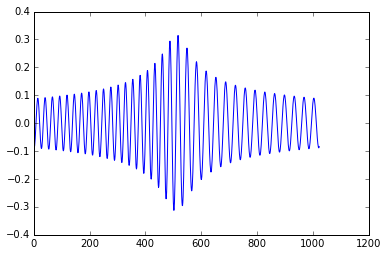

In [47]:
plt.plot(np.real(signal))

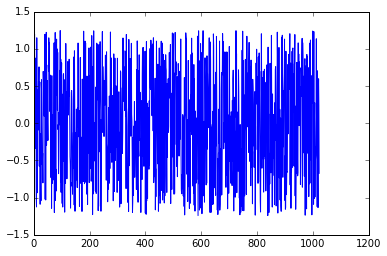

In [48]:
plt.plot(np.real(noise))

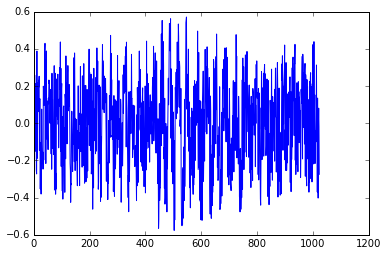

In [49]:
plt.plot(np.real(noised_signal))

In [53]:
c_a, c_d6, c_d5, c_d4, c_d3, c_d2, c_d1 = coeffs = pywt.wavedec(noised_signal, 'sym8', level=6)

In [57]:
threshold = max(noised_signal)/2
c_d6_thr = pywt._thresholding.soft(c_d6, threshold)
c_d5_thr = pywt._thresholding.soft(c_d5, threshold)
c_d4_thr = pywt._thresholding.soft(c_d4, threshold)
c_d3_thr = pywt._thresholding.soft(c_d3, threshold)
c_d2_thr = pywt._thresholding.soft(c_d2, threshold)
c_d1_thr = pywt._thresholding.soft(c_d1, threshold)
coeffs_thr = [c_a, c_d6_thr, c_d5_thr, c_d4_thr, c_d3_thr, c_d2_thr, c_d1_thr]

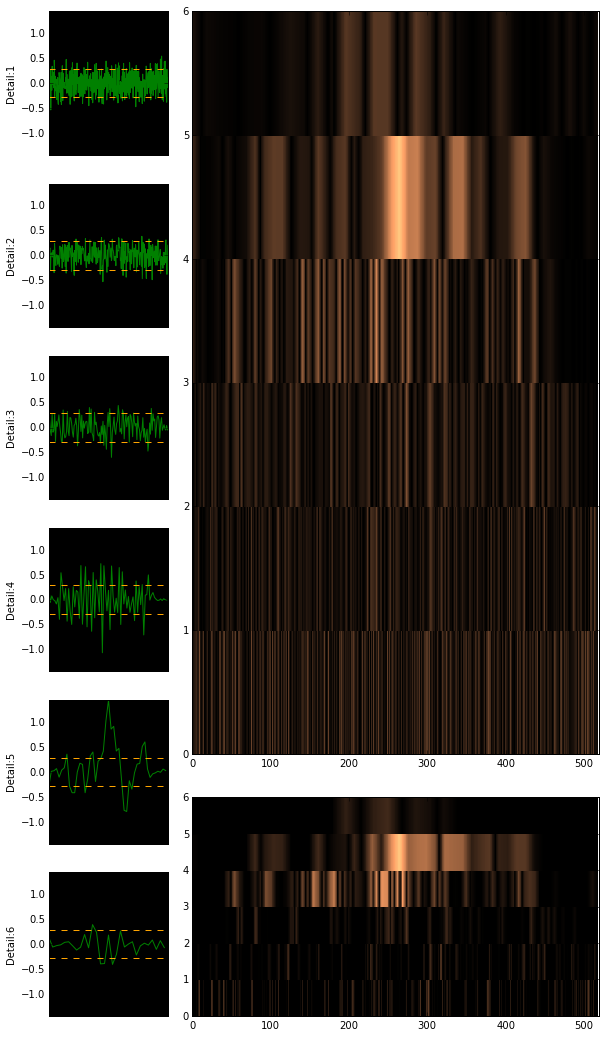

In [58]:
plot_detailed_decomposition_coefficients(coeffs, coeffs_thr, threshold)

In [59]:
rec_wave = pywt.waverec(coeffs_thr, 'sym8')

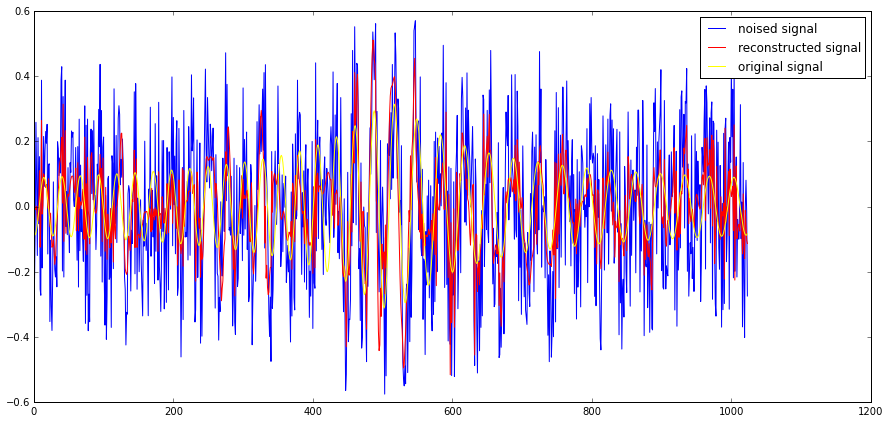

In [60]:
plot_signal_comparision(signal, noised_signal, rec_wave)

In [61]:
print("mean squered error:",metrics.mean_squared_error(np.real(rec_wave), np.real(signal)))

('mean squered error:', 0.013107908231934084)


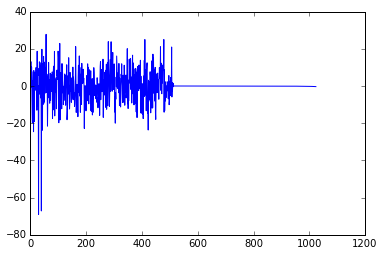

In [70]:
ff_signal_freq = np.fft.fft(noised_signal)
plt.plot(ff_signal_freq)

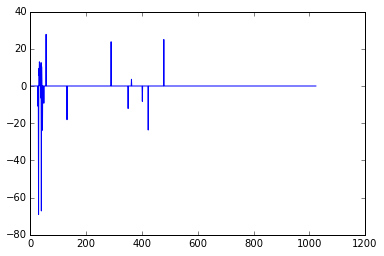

In [71]:
threshold = max(ff_signal_freq)*0.95
freq_trh = pywt._thresholding.hard(ff_signal_freq, threshold)
plt.plot(freq_trh)

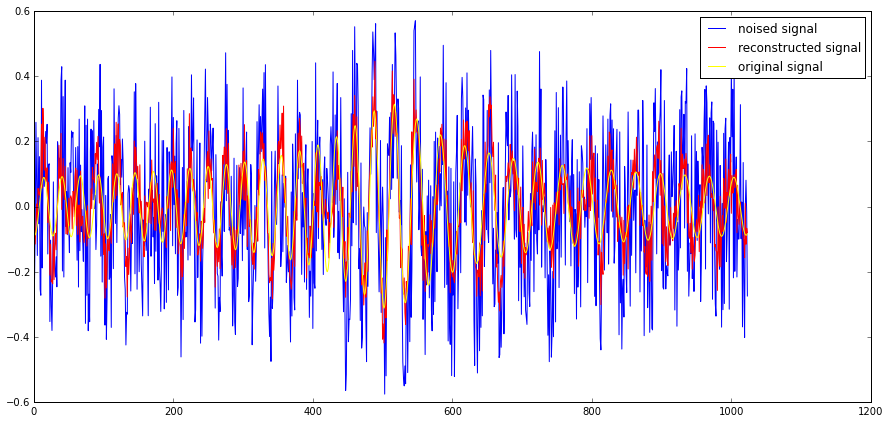

In [72]:
rec_fft = np.fft.ifft(freq_trh)
plot_signal_comparision(signal, noised_signal, rec_fft)

In [73]:
print("mean squered error of FFT based noise removal:",metrics.mean_squared_error(np.real(rec_fft), np.real(signal)))
print("mean squered error of Wavelet based noise removal:",metrics.mean_squared_error(np.real(rec_wave), np.real(signal)))

('mean squered error of FFT based noise removal:', 0.0066987658685480726)
('mean squered error of Wavelet based noise removal:', 0.013107908231934084)


## 1-d signall compression

Try using the same signall compress it most efficiently with wavelet transformation.
To check how sparse is your signal you can use defined function to compute eliminated coefficients ratio from earlier tutorial.
Check sparsity and plot signals

## 1-d signal frequency change
In this task your goal is to find where frequency of given signal changed. In order to do that it might be smart to decompose signal and carefully check what is going on with its coefficients

In [123]:
dist = tftb.processing.WignerVilleDistribution(signal)

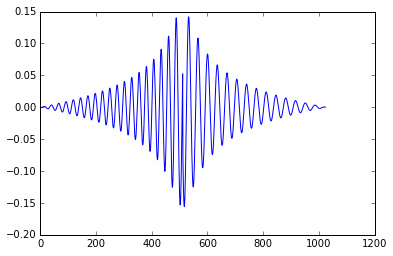

In [124]:
plt.plot(np.real(am*(dist.freqs*fm)))

In [142]:
c_a, c_d6, c_d5, c_d4, c_d3, c_d2, c_d1 = coeffs = pywt.wavedec(noised_signal, 'sym8', level=6)

In [143]:
threshold = max(noised_signal)
c_d6_thr = pywt._thresholding.soft(c_d6, threshold)
c_d5_thr = pywt._thresholding.soft(c_d5, threshold)
c_d4_thr = pywt._thresholding.soft(c_d4, threshold)
c_d3_thr = pywt._thresholding.soft(c_d3, threshold)
c_d2_thr = pywt._thresholding.soft(c_d2, threshold)
c_d1_thr = pywt._thresholding.soft(c_d1, threshold)
coeffs_thr = [c_a, c_d6_thr, c_d5_thr, c_d4_thr, c_d3_thr, c_d2_thr, c_d1_thr]

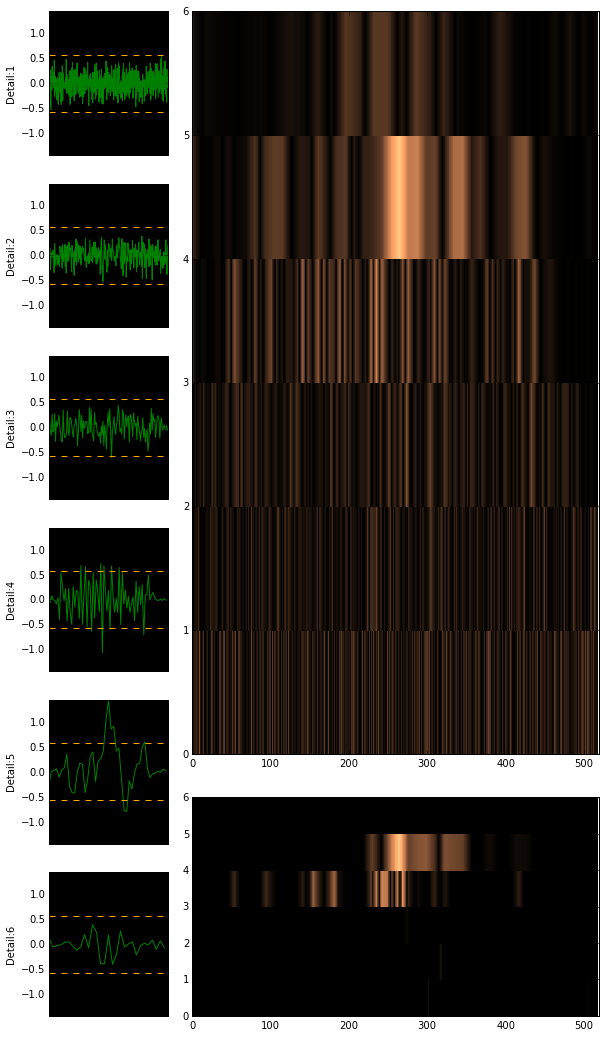

In [144]:
plot_detailed_decomposition_coefficients(coeffs, coeffs_thr, threshold)

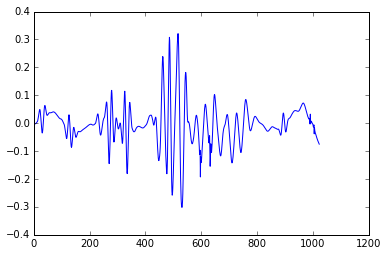

In [145]:
rec_wave = pywt.waverec(coeffs_thr, 'sym8')
plt.plot(rec_wave)

##  2-d image noise reduction

In this exercisse you will remove noise from an image

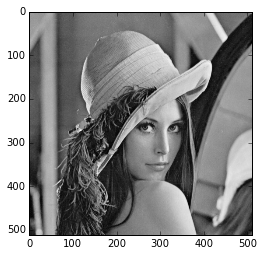

In [151]:
lena = misc.lena()
plt.imshow(lena, cmap=plt.cm.gray)

In [181]:
noisy_lena = lena + 2.2 * lena.std() * np.random.random(lena.shape)

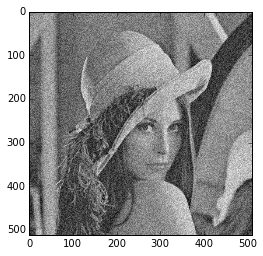

In [182]:
plt.imshow(noisy_lena, cmap='gray')

In [183]:
(ca, (cd11, cd12, cd13)) = coeffs = pywt.dwt2(lena, 'db2')

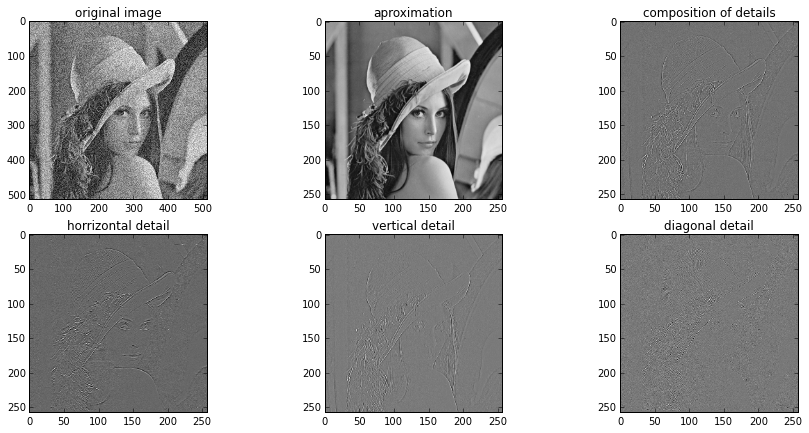

In [176]:
plot_matrix_coeff(noisy_lena, coeffs)

In [187]:
threshold = noisy_lena.max()/2
coeffs_thr1 = pywt._thresholding.soft(coeffs[1][0], threshold)
coeffs_thr2 = pywt._thresholding.soft(coeffs[1][1], threshold)
coeffs_thr3 = pywt._thresholding.soft(coeffs[1][2], threshold)

In [190]:
lena_rec = pywt.idwt2([coeffs[0],(coeffs_thr1, coeffs_thr2, coeffs_thr3)], 'db2')

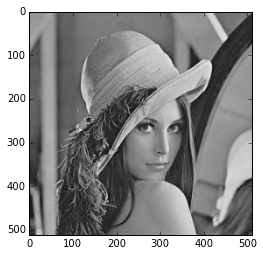

In [192]:
plt.imshow(lena_rec, cmap='gray')

In [ ]:
np.ga